Mateusz Mulka - projekt zaliczeniowy text mining

# Importy

In [19]:
!pip install --upgrade pip setuptools wheel --quiet
!pip install datasets transformers scikit-learn nltk wordcloud --quiet
!pip install imblearn --quiet
!pip install evaluate --quiet

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer
import evaluate
import matplotlib.pyplot as plt
from datasets import load_dataset
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from wordcloud import WordCloud
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import f1_score

# Pobranie zasobów NLTK
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Wstępne przygotowanie

Zbiór danych posiada trzy klasy sentymentu: 0=negative, 1=neutral, 2=positive.

In [3]:
dataset = load_dataset("tweet_eval", "sentiment")
df_train = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])

print("Przykładowe dane treningowe:")
df_train.head()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.78M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/901k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/167k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45615 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12284 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Przykładowe dane treningowe:


,text,label
0,"""QT @user In the original draft of the 7th boo...",2
1,"""Ben Smith / Smith (concussion) remains out of...",1
2,Sorry bout the stream last night I crashed out...,1
3,Chase Headley's RBI double in the 8th inning o...,1
4,@user Alciato: Bee will invest 150 million in ...,2


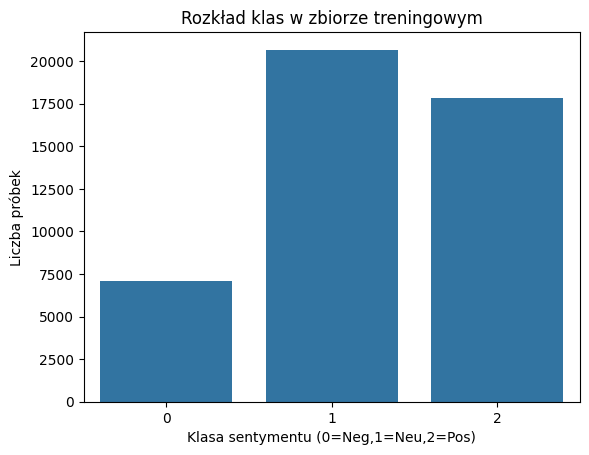

In [6]:
sns.countplot(x=df_train['label'])
plt.title("Rozkład klas w zbiorze treningowym")
plt.xlabel("Klasa sentymentu (0=Neg,1=Neu,2=Pos)")
plt.ylabel("Liczba próbek")
plt.show()


Widzimy, że klasa '0' jest najmniej liczna, użyję zatem metody oversamplingu RandomOversampler aby zbalansować dane

Liczebność poszczególnych klas po zbalansowaniu:
label
2    20673
1    20673
0    20673
Name: count, dtype: int64


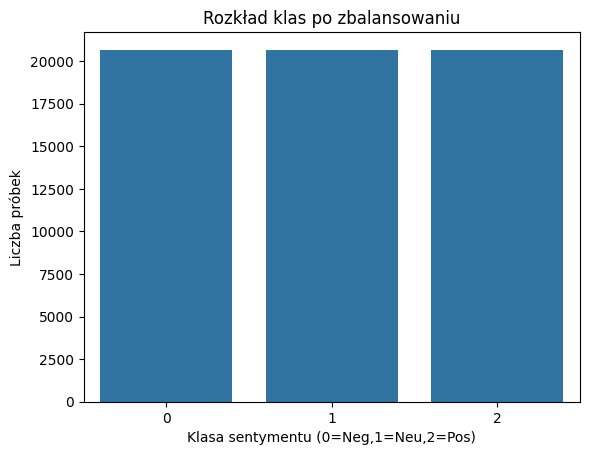

In [7]:
X_resampled = df_train[['text', 'label']]  # Tymczasowy DataFrame

# Podział na cechy (X) i etykiety (y)
X = X_resampled['text']
y = X_resampled['label']

X = X.values.reshape(-1,1) # dostosowanie kształtu do oversamplera
ros = RandomOverSampler(random_state=7)
X_res, y_res = ros.fit_resample(X, y)

# Tworzymy zbalansowany DataFrame
df_train_balanced = pd.DataFrame({'text': X_res.flatten(), 'label': y_res})

print("Liczebność poszczególnych klas po zbalansowaniu:")
print(df_train_balanced['label'].value_counts())

sns.countplot(x=df_train_balanced['label'])
plt.title("Rozkład klas po zbalansowaniu")
plt.xlabel("Klasa sentymentu (0=Neg,1=Neu,2=Pos)")
plt.ylabel("Liczba próbek")
plt.show()


Czyszczenie tekstu

In [8]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Usuwanie URLi
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Usuwanie znaków @, # i innych znaków specjalnych
    text = re.sub(r'[\@\#\.\,\!\?\:\;\-\_]', ' ', text)
    # Usuwanie dodatkowych białych znaków
    text = re.sub(r'\s+', ' ', text).strip()
    # Małe litery
    text = text.lower()
    # Tokenizacja
    tokens = text.split()
    # Usuwanie stopwords i lematyzacja
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return ' '.join(tokens)

df_train_balanced['clean_text'] = df_train_balanced['text'].apply(clean_text)
df_test['clean_text'] = df_test['text'].apply(clean_text)


# Uczenie modeli

Podział na zbiory treningowy, testowy i walidacyjny

In [9]:
train_texts, val_texts, train_labels, val_labels = train_test_split(df_train_balanced['clean_text'],
                                                                  df_train_balanced['label'],
                                                                  test_size=0.2,
                                                                  random_state=7,
                                                                  stratify=df_train_balanced['label'])

test_texts = df_test['clean_text']
test_labels = df_test['label']

vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=5)
X_train = vectorizer.fit_transform(train_texts)
X_val = vectorizer.transform(val_texts)
X_test = vectorizer.transform(test_texts)


Regresja logistyczna

In [10]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=7)
lr.fit(X_train, train_labels)

val_preds_lr = lr.predict(X_val)
print("Wyniki walidacji (Logistic Regression) po zbalansowaniu:")
print(classification_report(val_labels, val_preds_lr, digits=4))


Wyniki walidacji (Logistic Regression) po zbalansowaniu:
              precision    recall  f1-score   support

           0     0.7930    0.8532    0.8220      4135
           1     0.6612    0.6457    0.6534      4135
           2     0.7370    0.6984    0.7172      4134

    accuracy                         0.7324     12404
   macro avg     0.7304    0.7324    0.7308     12404
weighted avg     0.7304    0.7324    0.7308     12404



SVM

In [11]:
svc = LinearSVC(class_weight='balanced', random_state=7)
svc.fit(X_train, train_labels)

val_preds_svc = svc.predict(X_val)
print("Wyniki walidacji (SVM) po zbalansowaniu:")
print(classification_report(val_labels, val_preds_svc, digits=4))


Wyniki walidacji (SVM) po zbalansowaniu:
              precision    recall  f1-score   support

           0     0.8194    0.9226    0.8679      4135
           1     0.6851    0.6239    0.6531      4135
           2     0.7328    0.7059    0.7191      4134

    accuracy                         0.7508     12404
   macro avg     0.7457    0.7508    0.7467     12404
weighted avg     0.7458    0.7508    0.7467     12404



Widzimy, że oba moedle dają względnie podobne wyniki, przy czym SVM radzi sobie nieznacznie lepiej, należy tutaj pamiętać, że oba modele zostały stworzone w bardzo podstawowy sposób, bardziej zaawansowana analiza tych modeli dostępna jest w moim innym repozytorium https://github.com/kottoization/MachineLearning/tree/main

Warty zauważenia jest fakt, że zależy nam przede wszystkim na klasyfikacji ocen pozytywnych i negatywnych, a więc 0 i 2 - tutaj w obu przypadkach model SVM poradził sobie znacznie lepiej niż regresja logistyczna.

Ewaluacja na zbiorze testowym

In [12]:
test_preds_lr = lr.predict(X_test)
test_preds_svc = svc.predict(X_test)

print("Wyniki testowe (Logistic Regression) po zbalansowaniu:")
print(classification_report(test_labels, test_preds_lr, digits=4))

print("Wyniki testowe (SVM) po zbalansowaniu:")
print(classification_report(test_labels, test_preds_svc, digits=4))

Wyniki testowe (Logistic Regression) po zbalansowaniu:
              precision    recall  f1-score   support

           0     0.4704    0.7563    0.5800      3972
           1     0.6390    0.3876    0.4825      5937
           2     0.5568    0.5385    0.5475      2375

    accuracy                         0.5360     12284
   macro avg     0.5554    0.5608    0.5367     12284
weighted avg     0.5686    0.5360    0.5266     12284

Wyniki testowe (SVM) po zbalansowaniu:
              precision    recall  f1-score   support

           0     0.4904    0.6745    0.5679      3972
           1     0.6231    0.4213    0.5027      5937
           2     0.4845    0.5726    0.5249      2375

    accuracy                         0.5324     12284
   macro avg     0.5327    0.5561    0.5318     12284
weighted avg     0.5534    0.5324    0.5281     12284



W przypadku sprawdzenia zbioru testowego nasze wyniki nie są już aż tak wysokie, w realnym przepadku warto przetestować inne parametry modeli, sprawdzić inne proporcje balansowania danych - dodatkowo zadbać o zbalansowanie danych testowych, przykładowo w naszym przypadku prawdopodobnie zostało dodane zbyt dużo rekordów o negatywnym sentymencie.

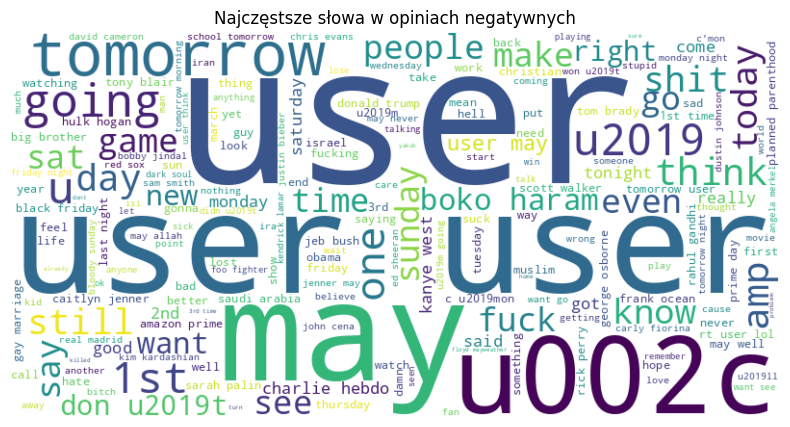

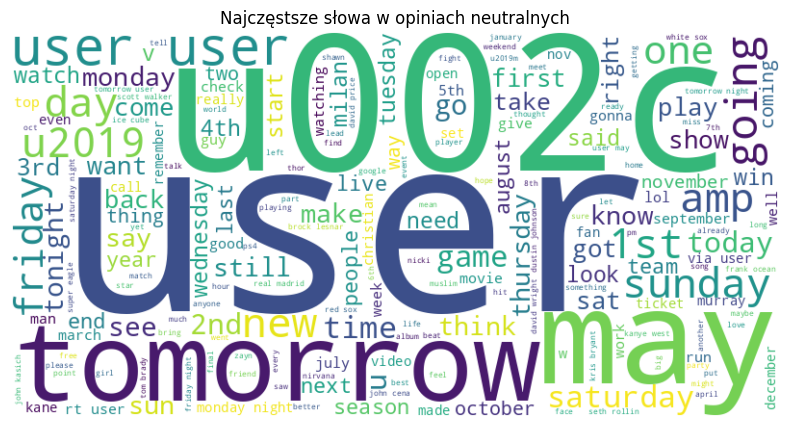

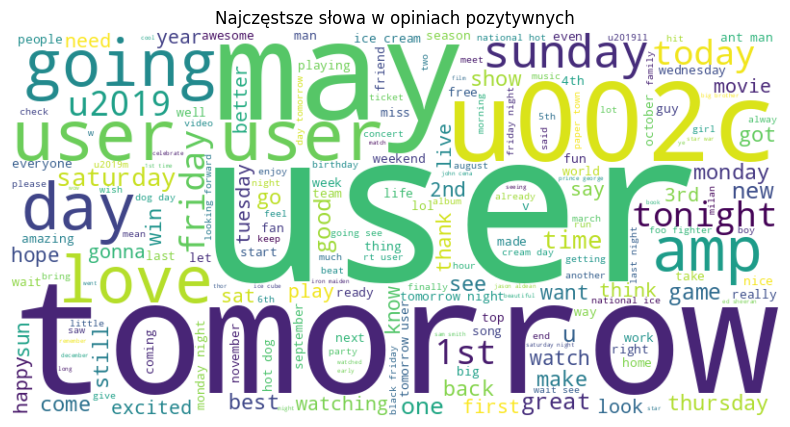

In [13]:
neg_texts = " ".join(df_train_balanced[df_train_balanced['label']==0]['clean_text'].values)
neu_texts = " ".join(df_train_balanced[df_train_balanced['label']==1]['clean_text'].values)
pos_texts = " ".join(df_train_balanced[df_train_balanced['label']==2]['clean_text'].values)

def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

plot_wordcloud(neg_texts, "Najczęstsze słowa w opiniach negatywnych")
plot_wordcloud(neu_texts, "Najczęstsze słowa w opiniach neutralnych")
plot_wordcloud(pos_texts, "Najczęstsze słowa w opiniach pozytywnych")


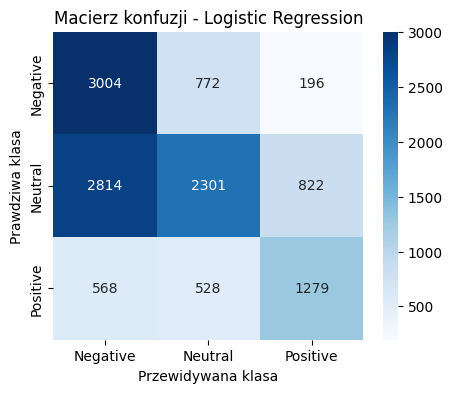

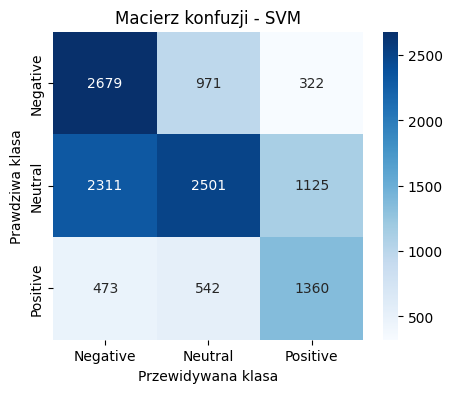

In [14]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative','Neutral','Positive'], yticklabels=['Negative','Neutral','Positive'])
    plt.title(title)
    plt.ylabel('Prawdziwa klasa')
    plt.xlabel('Przewidywana klasa')
    plt.show()

plot_confusion_matrix(test_labels, test_preds_lr, "Macierz konfuzji - Logistic Regression")
plot_confusion_matrix(test_labels, test_preds_svc, "Macierz konfuzji - SVM")

Widzimy największą liczbę błędów przy przewidywaniu negatywnych komentarzy jako tych neutralnych.

Prawdopodobnie dobrym pomysłem jest zastosowanie tutaj bardziej zaawansowanego modelu NLP jak na przykład BERT.

BERT


In [21]:
# Tworzymy dataset w formacie Hugging Face z istniejących już df'ów:
train_data = Dataset.from_dict({"text": train_texts.tolist(), "label": train_labels.tolist()})
val_data = Dataset.from_dict({"text": val_texts.tolist(), "label": val_labels.tolist()})
test_data = Dataset.from_dict({"text": test_texts.tolist(), "label": test_labels.tolist()})


Łączymy datasety w DatasetDict aby latwo bylo zarzadzac zestawami danych, nastepnie wybieramy bazowy model DistilBERT

In [22]:
dataset = DatasetDict({
    "train": train_data,
    "validation": val_data,
    "test": test_data
})

model_checkpoint = "distilbert-base-uncased"
num_labels = 3
# Ładujemy tokenizer, który będzie dzielił tekst na tokeny kompatybilne z DistilBERT
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [23]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True)

Tokenizujemy dataset

In [24]:
tokenized_dataset = dataset.map(tokenize_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

# Metryki
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

Map:   0%|          | 0/49615 [00:00<?, ? examples/s]

Map:   0%|          | 0/12404 [00:00<?, ? examples/s]

Map:   0%|          | 0/12284 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Stosujemy metryki do ewaluacji modelu

In [25]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted')["f1"]
    precision = precision_metric.compute(predictions=predictions, references=labels, average='weighted')["precision"]
    recall = recall_metric.compute(predictions=predictions, references=labels, average='weighted')["recall"]
    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

In [28]:
# Sprawdzenie dostępności GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Trening DistilBERT na urządzeniu: {device}")
model.to(device)

# Ustawienia treningu:
# - Zapis wyników i modelu do 'distilbert-sentiment'
# - Ewaluacja co epokę, zapisywanie najlepszego modelu według F1
# - 3 epoki, batch_size=16, learning_rate=2e-5

training_args = TrainingArguments(
    output_dir="distilbert-sentiment",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    seed=7,  # Ustalony random_state
    no_cuda=(device=="cpu"),
    report_to=[]
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


Trening DistilBERT na urządzeniu: cuda


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-28-247ef0658511>:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [29]:
# Trening modelu DistilBERT
trainer.train()

# Ewaluacja na zbiorze testowym
test_results = trainer.evaluate(tokenized_dataset["test"])
print("Wyniki DistilBERT na zbiorze testowym:")
print(test_results)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.636700,0.615403,0.737101,0.735944,0.746393,0.737101
2,0.462000,0.554346,0.779587,0.775626,0.775866,0.779587
3,0.341200,0.591978,0.793051,0.789128,0.788845,0.793051


Wyniki DistilBERT na zbiorze testowym:
{'eval_loss': 1.060880422592163, 'eval_accuracy': 0.6427059589710192, 'eval_f1': 0.6415759812937266, 'eval_precision': 0.6479237592807526, 'eval_recall': 0.6427059589710192, 'eval_runtime': 11.3165, 'eval_samples_per_second': 1085.496, 'eval_steps_per_second': 67.866, 'epoch': 3.0}


In [30]:
# Raport klasyfikacji DistilBERT
predictions = trainer.predict(tokenized_dataset["test"])
pred_labels_bert = np.argmax(predictions.predictions, axis=-1)
true_labels_bert = np.array(tokenized_dataset["test"]["label"])
print("Raport klasyfikacji DistilBERT (zbiór testowy):")
print(classification_report(true_labels_bert, pred_labels_bert, digits=4))

Raport klasyfikacji DistilBERT (zbiór testowy):
              precision    recall  f1-score   support

           0     0.6241    0.7238    0.6702      3972
           1     0.6849    0.5787    0.6274      5937
           2     0.5955    0.6669    0.6292      2375

    accuracy                         0.6427     12284
   macro avg     0.6348    0.6565    0.6423     12284
weighted avg     0.6479    0.6427    0.6416     12284



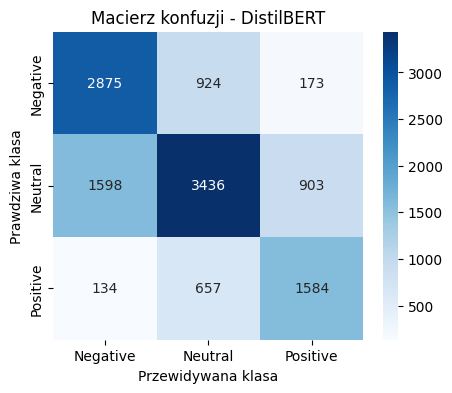

In [31]:
# Macierz konfuzji DistilBERT
cm = confusion_matrix(true_labels_bert, pred_labels_bert)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative','Neutral','Positive'],
            yticklabels=['Negative','Neutral','Positive'])
plt.title("Macierz konfuzji - DistilBERT")
plt.xlabel("Przewidywana klasa")
plt.ylabel("Prawdziwa klasa")
plt.show()

# Porównanie ze sobą modeli Regresji Logistycznej, SVM, BERT

Dobór odpowiedniej metryki zależy od specyfiki problemu oraz rozkładu danych. Jeśli zależy nam zarówno na wysokiej wykrywalności pozytywnych przypadków (wysoki recall), jak i na ograniczeniu fałszywych alarmów (wysoka precyzja), dobrym kompromisem będzie F1-score.

In [34]:
# Obliczanie F1-score dla każdego modelu
f1_lr = f1_score(test_labels, test_preds_lr, average='weighted')
f1_svc = f1_score(test_labels, test_preds_svc, average='weighted')
f1_bert = f1_score(test_labels, pred_labels_bert, average='weighted')

# Wyświetlenie wyników
print(f"F1-score Logistic Regression: {f1_lr:.4f}")
print(f"F1-score SVM: {f1_svc:.4f}")
print(f"F1-score DistilBERT: {f1_bert:.4f}")

F1-score Logistic Regression: 0.5266
F1-score SVM: 0.5281
F1-score DistilBERT: 0.6416


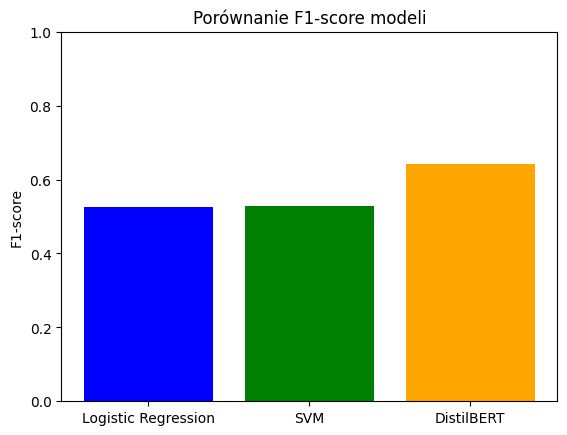

In [35]:
models = ['Logistic Regression', 'SVM', 'DistilBERT']
f1_scores = [f1_lr, f1_svc, f1_bert]

plt.bar(models, f1_scores, color=['blue', 'green', 'orange'])
plt.ylabel("F1-score")
plt.title("Porównanie F1-score modeli")
plt.ylim(0, 1)
plt.show()

Jak można łatwo zaobserwować model BERT poradził sobie z analizą lepiej niż dwa wcześniej użyte modele.

Aby poprawić wyniki DistilBERT, można rozważyć następujące kroki:

- Fine-tuning na większej liczbie danych.
- Dłuższy trening: Zwiększenie liczby epok, przy jednoczesnym monitorowaniu metryk walidacyjnych, może pomóc modelowi lepiej dopasować się do danych.
- Eksperymentowanie z hiperparametrami: zmiana learning rate, batch size lub zastosowanie innych strategii np dropout, aby uniknąć przeuczenia, może poprawić wyniki modelu.
- Lepszy preprocessing: Ten punkt był już opisany wcześniej jednak można użyć innych metod preprocessingu, na przykład przyłożyć większą uwagę do optymalnego procesu balansowania zbiorów testowych i uczących.
- Zastosowanie pełnego BERT-a lub bardziej zaawansowanego modelu (np. RoBERTa): Modele takie jak RoBERTa mogą osiągać lepsze wyniki w porównaniu z DistilBERT, choć kosztem większego zapotrzebowania na zasoby obliczeniowe.